# Training a Solubility Model using Extended Connectivity Fingerprints

In this notebook, I use the solubility dataset curated by Lowe _et. al._ (2023) and trained a classification model for predicting the solubility of compounds using Extended Connectivity Fingerprints (ECFP) calculated for radius 3, hence ECFP6. I train several classical machine learning models and evaluate their performance using 5-fold cross validation. 

Here is my data path.

In [1]:
data_path = "../data/01_raw/tx2c00379_si_002.xlsx"

Load the data and list the names of worksheets.

In [2]:
import pandas as pd
data = pd.ExcelFile(data_path)
data.sheet_names

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


['Table of Contents',
 'S1. Training Data',
 'S2. Test Data',
 'S3. Descriptors',
 'S4. CV Folds Performance',
 'S5. Original Data']

I use the "S1. Training Data" worksheet to train my models. I'll not train the models using the chemical descriptors provided in this sheet. Instead, I'll use the standardized SMILES and create ECFP6s.

In [3]:
train = pd.read_excel(data_path, sheet_name='S1. Training Data')
train.head()

,XLogP,GATS1s,GATS1m,GATS1e,GATS1p,GATS1i,GATS2e,GATS1v,GATS1c,SIC0,ZMIC3,piPC7,piPC5,nAcid,nHBAcc,nHBDon,median_WS,Standardized_SMILES
0,0.936498,-0.970370,-0.480993,-0.877541,-0.745284,-0.937635,-1.083567,-0.766023,-0.008895,-0.206037,0.715794,0.550312,0.611528,-0.348025,-0.021412,-0.046488,-2.271500,O=C(NC(=O)C1C=CC=CC=1)C1C=CC=CC=1
1,0.342767,-1.043955,-1.473961,-1.022654,-1.335317,-0.720439,-0.192275,-1.200827,-1.193408,1.140815,-0.023417,0.629892,0.541051,-0.348025,-0.021412,-0.789426,-3.382172,O=C1C(Cl)=C(Cl)C=NN1C1C=CC=CC=1
2,0.067360,-1.179478,-0.386046,-1.366302,-0.623350,-1.118630,-0.174790,-0.567204,-2.592873,0.168601,-0.472455,-0.233875,0.054378,-0.348025,-0.776753,-0.789426,-1.201546,O=CC1C=CC=CC=1
3,-0.862942,-0.327086,-0.136440,-1.041726,0.480663,0.082138,-0.878888,-0.522815,0.179127,0.878502,0.221784,0.683945,0.603033,-0.348025,1.111600,-0.046488,-3.128816,NS(=O)(=O)CCN1C(=O)C2=CC=CC=C2C1=O
4,-0.273942,-0.718723,-1.606037,-2.058297,-0.684827,-0.542332,-0.642154,-0.469959,-1.977194,1.092923,0.815359,0.868703,0.804197,-0.348025,-0.776753,-0.789426,-3.559450,CN(C1C(=CC(=CC=1[N+]([O-])=O)[N+]([O-])=O)[N+]...


Disable RDKit warning messages before I start.

In [4]:
from rdkit import RDLogger
logger = RDLogger.logger()
logger.setLevel(RDLogger.ERROR)

I, first, create molecules from the SMILES.

In [11]:
from rdkit.Chem import MolFromSmiles
from tqdm.notebook import tqdm
ROMols = [MolFromSmiles(smiles) for smiles in tqdm(train['Standardized_SMILES'].values)]

  0%|          | 0/7655 [00:00<?, ?it/s]

Now, create ECFPs for radius 3 and 1024 bits. I create a 'create_ecfp' function first. Then, create ECFPs from ROMols using list comprehension.

In [12]:
import rdkit
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import DataStructs
import numpy as np

def create_ecfp(
        mol: rdkit.Chem.rdchem.Mol,
        radius: int = 3,
        nbits: int = 1024
        ) -> np.ndarray:
    
    mfbitvector = GetMorganFingerprintAsBitVect(mol, radius, nbits)
    arr = np.zeros((1,0))
    DataStructs.ConvertToNumpyArray(mfbitvector, arr)
    
    return arr

In [13]:
X_train = [create_ecfp(mol) for mol in tqdm(ROMols)]

  0%|          | 0/7655 [00:00<?, ?it/s]

<Axes: >

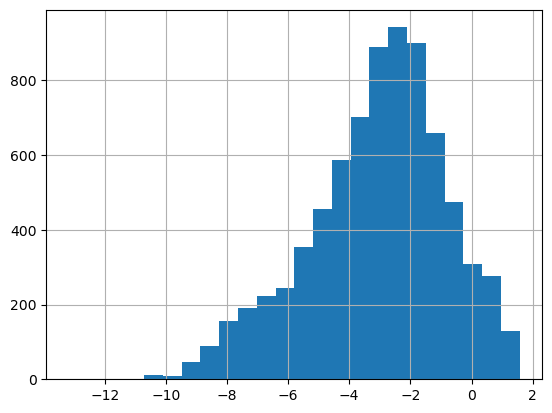

In [14]:
train['median_WS'].hist(bins=24)

In [15]:
cutoff = -3.0

In [19]:
y_train = [int(1) if val >= cutoff else int(0) for val in train['median_WS'].values]

In [21]:
test = pd.read_excel(data_path, sheet_name='S2. Test Data')
test.head()

,XLogP,GATS1s,GATS1m,GATS1e,GATS1p,GATS1i,GATS2e,GATS1v,GATS1c,SIC0,ZMIC3,piPC7,piPC5,nAcid,nHBAcc,nHBDon,median_WS,Standardized_SMILES
0,0.030189,-0.598558,-0.886614,-1.029329,-0.690235,-1.125166,-0.852255,-0.725795,-0.944007,0.723388,-0.291472,0.395987,0.335983,1.448422,-0.021412,-0.046488,-1.843351,[O-][N+](=O)C(C=O)(C(O)=O)C1C=CC=CC=1
1,-0.884231,-1.029376,-1.417321,-0.588051,-0.925781,0.909000,1.183894,-0.293145,-0.623136,2.017216,0.099767,-0.907523,-0.785089,-0.348025,-0.399083,-0.789426,-1.647815,[O-][N+](=O)C1(Br)COCOC1
2,0.176171,-0.293186,-0.921390,-0.334045,-2.393419,-1.446137,0.774464,-2.601347,-1.977901,1.718908,1.575567,0.739924,0.753993,-0.348025,-1.154424,-0.046488,-0.604970,[O-][N+](=O)C1=C(Cl)C(=C(O)C(=C1Cl)[N+]([O-])=...
3,1.106136,-0.816131,-1.066304,-1.664537,-1.162705,-1.522933,-0.882860,-1.063556,-1.349506,0.266739,0.051396,1.307355,1.188515,-0.348025,-0.399083,-0.046488,-7.729934,[O-][N+](=O)C1=CC(=C(C=C1)N=NC1=C(O)C=CC2=CC=C...
4,0.816198,-0.758524,-1.370797,-1.232891,-1.842923,-1.567968,-0.295173,-1.532958,-1.420371,0.980637,1.353024,0.916827,0.908909,-0.348025,-1.154424,-0.046488,-6.663700,[O-][N+](=O)C1=CC(=C(C=C1)ON=CC1=CC(Br)=C(O)C(...


In [22]:
ROMols = [MolFromSmiles(smiles) for smiles in tqdm(test['Standardized_SMILES'].values)]
X_test = [create_ecfp(mol) for mol in tqdm(ROMols)]
y_test = [int(1) if val >= cutoff else int(0) for val in test['median_WS'].values]

  0%|          | 0/2552 [00:00<?, ?it/s]

  0%|          | 0/2552 [00:00<?, ?it/s]

## Modeling

In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,max_depth=40,random_state=7)
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)

In [24]:
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                            matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay)

In [25]:
acc = accuracy_score(y_test,predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
mcc = matthews_corrcoef(y_test, predictions)
print([acc, precision, recall, mcc])

[0.8025078369905956, 0.8086158192090396, 0.8309143686502177, 0.6017924560102653]


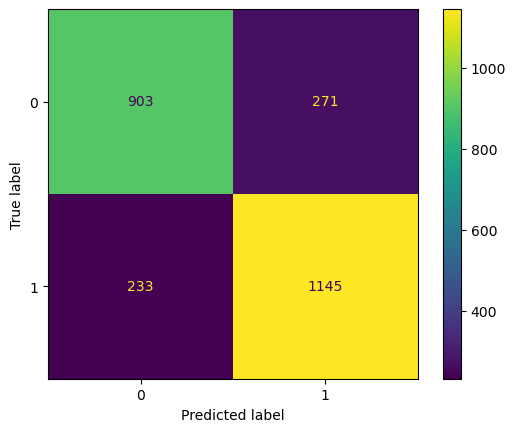

In [26]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [28]:
import joblib
model_path = "../models/solubility_model.joblib"
joblib.dump(clf,model_path)

['../models/solubility_model.joblib']